In [11]:
import numpy as np
import matplotlib.pyplot as plt

3.1 Batch mode training using least squares - supervised learning of network weights

In [12]:
# Create data

x_train = []
x_test = []

stepsize = 0.1
n_steps = int(2*np.pi/stepsize)
for i in range(n_steps):
    x_train.append(stepsize*i)
    x_test.append(stepsize*i+0.05)

x_train = np.array(x_train)
x_test = np.array(x_test)

sin_train = np.sin(2*x_train)
squ_train = np.array([-1 if i < 0 else 1 for i in sin_train])

sin_test = np.sin(2*x_test)
squ_test = np.array([-1 if i < 0 else 1 for i in sin_test])

In [81]:
class RBF:
    def __init__(self, input_size, output_size, centers=None, nr_centers=None, range_x=None, range_y=None, width=0.1):
        self.input_size = input_size
        self.output_size = output_size

        if centers is not None:
            # Ensure centers is 2D (if centers are 1D, reshape to 2D)
            centers = np.array(centers)
            if centers.ndim == 1:
                centers = centers.reshape(-1, 1)
            self.centers = centers
            self.hidden_size = len(centers)
        else:  # Competitive Learning case
            self.hidden_size = nr_centers
            self.centers = np.random.uniform(range_x[0], range_x[1], size=(self.hidden_size, self.input_size))
            if range_y is not None:
              self.centers = np.random.uniform(range_y[0], range_y[1], size=(self.hidden_size, self.input_size))

        self.weights = np.random.normal(0, 1, size=(self.hidden_size, output_size))
        self.width = width


    def _train_centers_CL_hard_competition(self, X_train, y_train, epochs=200, lr=0.01, plot=True):
        # Reshape 1D input/output to 2D
        if X_train.ndim == 1:
            X_train = X_train.reshape(-1, 1)
        if y_train.ndim == 1:
            y_train = y_train.reshape(-1, 1)

        # Learning phase
        for _ in range(epochs * X_train.shape[0]):
            shuffled_indices = np.random.permutation(X_train.shape[0])
            selected_X = X_train[shuffled_indices[0]]
            selected_y = y_train[shuffled_indices[0]]

            # Find the closest unit
            idx_min_distance = 0
            min_distance = np.inf
            for n in range(self.hidden_size):
                distance = np.linalg.norm(selected_X - self.centers[n])
                if distance < min_distance:
                    idx_min_distance = n
                    min_distance = distance

            # Update the closest unit
            self.centers[idx_min_distance] += lr * (selected_X - self.centers[idx_min_distance])

        if plot:
            plt.scatter(self.centers, np.zeros(self.hidden_size))
            plt.title('Final center placement')
            plt.ylim(-1,1)
            plt.show()

    def _kernel_function(self, X):
        # Ensure X is 2D if it's 1D
        if X.ndim == 1:
            X = X.reshape(-1, self.input_size)

        # Use the input centers only
        input_centers = self.centers[:, :self.input_size]

        # Compute Gaussian RBFs based on the input dimensions
        phi = np.exp(-np.sum((X[:, np.newaxis, :] - input_centers[np.newaxis, :, :])**2, axis=2) / (2 * self.width**2))

        return phi

    def _train_least_squares(self, X_train, y_train, X_test=None, y_test=None):
        # Reshape data if 1D
        if X_train.ndim == 1:
            X_train = X_train.reshape(-1, 1)
        if y_train.ndim == 1:
            y_train = y_train.reshape(-1, 1)
        if X_test is not None and X_test.ndim == 1:
            X_test = X_test.reshape(-1, 1)
        if y_test is not None and y_test.ndim == 1:
            y_test = y_test.reshape(-1, 1)

        # Implement least squares optimization
        phi_matrix = self._kernel_function(X_train)
        self.weights = np.linalg.lstsq(phi_matrix.T @ phi_matrix, phi_matrix.T @ y_train, rcond=None)[0]

        training_error = self._absolute_residual_error(X_train, y_train)
        if X_test is not None:
            testing_error = self._absolute_residual_error(X_test, y_test)
            return training_error, testing_error
        else:
            return training_error


    def _train_sequential(self, X_train, y_train, X_test=None, y_test=None, lr=0.01, epochs=10, CL=False):
      # Reshape input/output if 1D
      if X_train.ndim == 1:
          X_train = X_train.reshape(-1, self.input_size)  # Shape (n_samples, 1) for 1D input
      if y_train.ndim == 1:
          y_train = y_train.reshape(-1, self.output_size)  # Shape (n_samples, 1) for 1D output
      if X_test is not None and X_test.ndim == 1:
          X_test = X_test.reshape(-1, self.input_size)
      if y_test is not None and y_test.ndim == 1:
          y_test = y_test.reshape(-1, self.output_size)

      training_error = []
      testing_error = []

      for _ in range(epochs):
          # Shuffle data for stochastic gradient descent
          shuffled_indices = np.random.permutation(X_train.shape[0])
          X_train = X_train[shuffled_indices]
          y_train = y_train[shuffled_indices]

          for i in range(X_train.shape[0]):
              # Forward pass: compute the output of the RBF network
              phi = self._kernel_function(np.array([X_train[i]]))  # Single sample kernel computation
              output = phi @ self.weights

              # Compute the error
              error = y_train[i] - output  # Error between predicted and true values

              # Update the weights of the output layer using the delta rule
              delta_weights = lr * np.outer(phi, error)  # Update based on the error
              self.weights += delta_weights  # Incremental weight update

          # Compute training error after the epoch
          training_error.append(self._absolute_residual_error(X_train, y_train))

          # If test data is provided, compute the testing error after the epoch
          if X_test is not None:
              testing_error.append(self._absolute_residual_error(X_test, y_test))

      # Return training and testing errors (if test data is provided)
      if X_test is not None:
          return training_error, testing_error
      else:
          return training_error


    def _absolute_residual_error(self, X_test, y_test):
        y_pred = self.predict(X_test)
        return np.mean(np.abs(y_pred - y_test))

    def predict(self, X_test):
        # Reshape X_test if it's 1D
        if X_test.ndim == 1:
            X_test = X_test.reshape(-1, self.input_size)

        phi_matrix = self._kernel_function(X_test)
        y_pred = phi_matrix @ self.weights
        return y_pred


Varying the number of units to obtain the absolute residual error below 0.1, 0.01 and 0.001

Testing Error: 0.0005203954130762283
Training Error: 0.000541211933678568


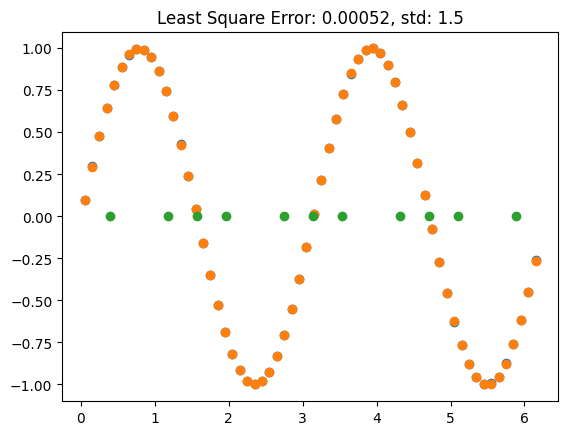

Testing Error: 0.0006906043795773498
Training Error: 0.0006677598097975811


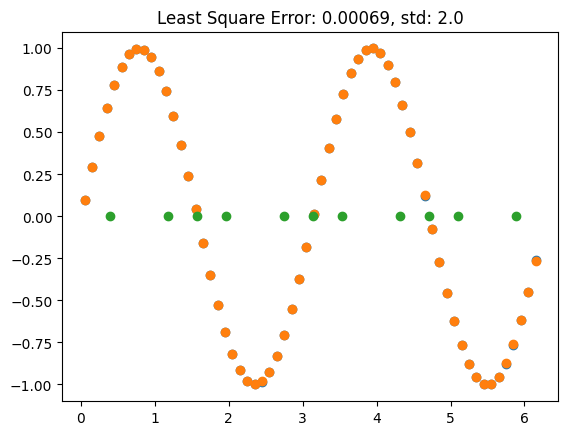

Testing Error: 0.00641535593019968
Training Error: 0.006519498805164747


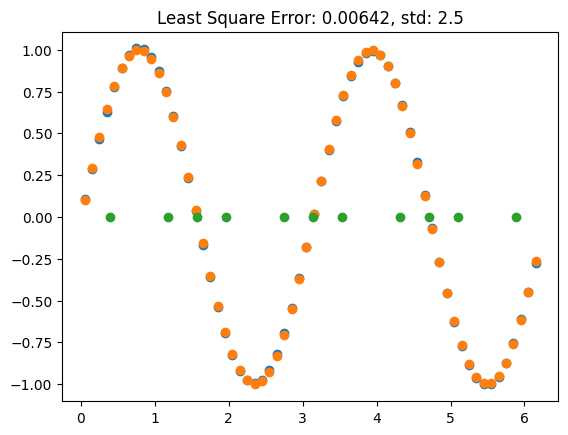

In [23]:
# Place center for sin

centers_sin = np.array([np.pi/8, np.pi*3/8, np.pi*5/8, np.pi*7/8, np.pi*9/8, np.pi*11/8, np.pi*13/8, np.pi*15/8, np.pi/2, np.pi, np.pi*3/2])
np.zeros((11))

# Sin
std_list = [1.5, 2, 2.5]

for std in std_list:
  rbf = RBF(input_size=1, output_size=1, centers=centers_sin, width = std)
  training_error_sin, testing_error_sin = rbf._train_least_squares(x_train, sin_train, x_test, sin_test)
  y_pred = rbf.predict(x_test)
  print('Testing Error: ' + str(testing_error_sin))
  print('Training Error: ' + str(training_error_sin))

  plt.plot(x_test, y_pred, 'o')
  plt.plot(x_test, sin_test, 'o')
  plt.plot(rbf.centers, np.zeros((11 , 1)), 'o')
  plt.title('Least Square Error: {:.5f}, std: {:.1f}'.format(testing_error_sin, std))
  plt.show()

How can you simply transform the output of your RBF network to reduce the residual error to 0 for the square(2x) problem? -> sign function

Testing Error: 0.9989594172736732
Training Error: 1.217663962492107e-15


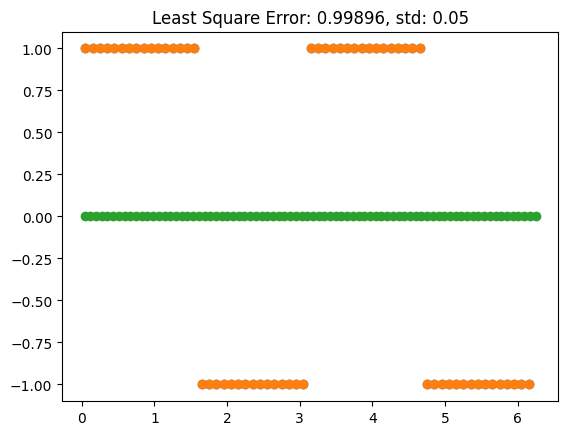

Testing Error: 0.9989594172736732
Training Error: 9.282897031704534e-15


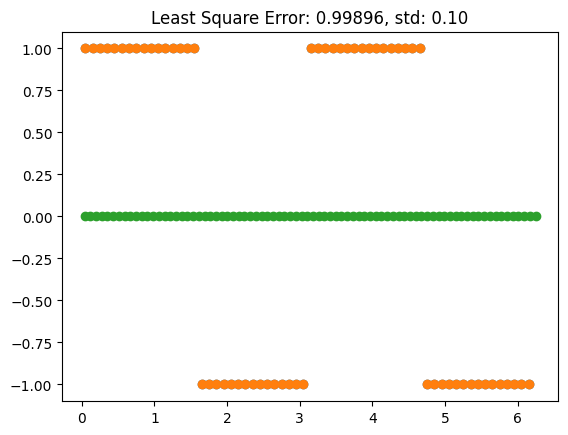

Testing Error: 0.9968782518210197
Training Error: 7.154647627038274e-10


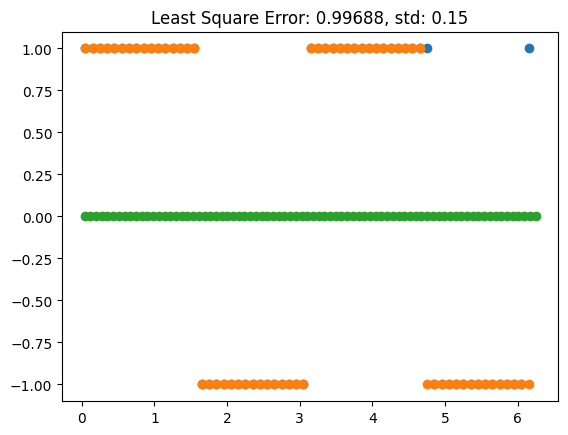

In [41]:
# Place center for squ
#centers_squ = np.array([[0, 1], [np.pi/4, 1], [np.pi/2, 1], [np.pi/2, -1], [np.pi*3/4, -1], [np.pi, -1], [np.pi, 1], [np.pi*5/4, 1], [np.pi*3/2, 1], [np.pi*3/2, -1], [np.pi*7/4, -1], [np.pi*2, -1]])

nr_centers = 80

intervals = np.linspace(0, 2*np.pi, num=nr_centers + 1)
centers_squ = ((intervals[:-1] + intervals[1:]) / 2).T


# Squ
std_list = [0.05, 0.1, 0.15]


for std in std_list:
  rbf = RBF(input_size=1, output_size=1, centers=centers_squ, width = std)
  training_error_squ, testing_error_squ = rbf._train_least_squares(x_train, squ_train, x_test, squ_test)
  y_pred = np.sign(rbf.predict(x_test))
  #y_pred = rbf.predict(x_test)
  testing_error_squ = np.mean(np.abs(y_pred - squ_test))
  print('Testing Error: ' + str(testing_error_squ))
  print('Training Error: ' + str(training_error_squ))

  plt.plot(x_test, y_pred, 'o')
  plt.plot(x_test, squ_test, 'o')
  plt.plot(rbf.centers, np.zeros(nr_centers), 'o')
  plt.title('Least Square Error: {:.5f}, std: {:.2f}'.format(testing_error_squ, std))
  plt.show()

In [42]:
# Create noisy data
noise_train = np.random.normal(0, 0.1, x_train.shape[0])
noisy_sin_train = np.sin(2*x_train) + noise_train

noisy_squ_train = squ_train + noise_train

Compare the effect of the number of RBF units and their width for the two learning approaches. Which error estimate should you choose as the criterion for these comparative analyses? -> testing error

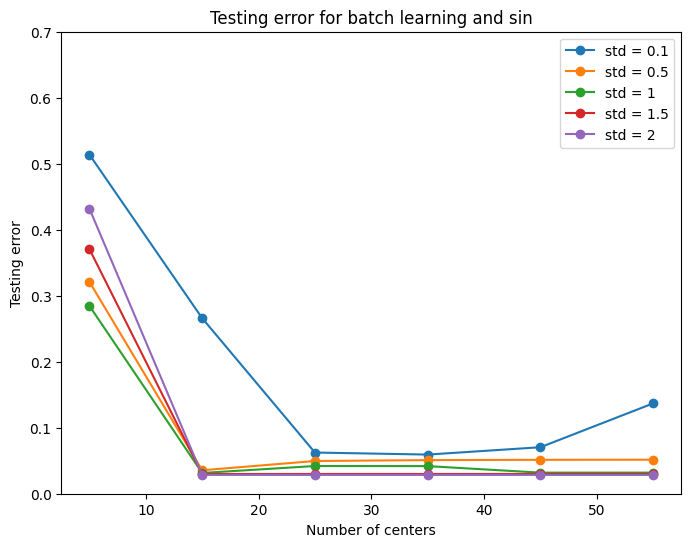

In [48]:
# batch
std_list = [0.1, 0.5, 1, 1.5, 2]
nr_centers_list = list(range(5, 65, 10))
lses = np.zeros((len(std_list), len(nr_centers_list)))


for i in range(len(std_list)):
  for n in range(len(nr_centers_list)):
    intervals = np.linspace(0, 2*np.pi, num=nr_centers_list[n] + 1)
    centers_noisy_sin_x = (intervals[:-1] + intervals[1:]) / 2
    centers_noisy_sin = np.array([centers_noisy_sin_x, np.sin(2*centers_noisy_sin_x)]).T

    rbf = RBF(input_size=1, output_size=1, centers=centers_noisy_sin, width = std_list[i])
    _, testing_error_noisy_sin = rbf._train_least_squares(x_train, noisy_sin_train, x_test, sin_test)
    lses[i, n] = testing_error_noisy_sin


n = np.arange(5, 65, 10)
plt.figure(figsize=(8, 6))
plt.plot(n, lses[0,:], 'o-', label = 'std = 0.1')
plt.plot(n, lses[1,:], 'o-', label = 'std = 0.5')
plt.plot(n, lses[2,:], 'o-', label = 'std = 1')
plt.plot(n, lses[3,:], 'o-', label = 'std = 1.5')
plt.plot(n, lses[4,:], 'o-', label = 'std = 2')
plt.ylim(0,0.7)
plt.xlabel('Number of centers')
plt.ylabel('Testing error')
plt.legend()
plt.title('Testing error for batch learning and sin')
plt.show()

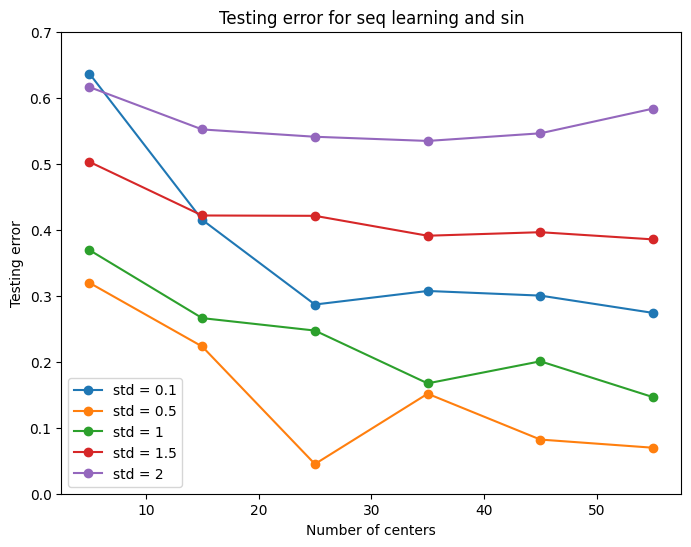

In [53]:
# Sequential learning

lses = np.zeros((len(std_list), len(nr_centers_list)))

for i in range(len(std_list)):
  for n in range(len(nr_centers_list)):
    intervals = np.linspace(0, 2*np.pi, num=nr_centers_list[n] + 1)
    centers_noisy_sin = ((intervals[:-1] + intervals[1:]) / 2).T

    rbf = RBF(input_size=1, output_size=1, centers=centers_noisy_sin, width = std_list[i])
    _, testing_error_noisy_sin = rbf._train_sequential(x_train, noisy_sin_train, x_test, sin_test, epochs = 50, lr = 0.01)
    lses[i, n] = testing_error_noisy_sin[-1]


n = np.arange(5, 65, 10)
plt.figure(figsize=(8, 6))
plt.plot(n, lses[0,:], 'o-', label = 'std = 0.1')
plt.plot(n, lses[1,:], 'o-', label = 'std = 0.5')
plt.plot(n, lses[2,:], 'o-', label = 'std = 1')
plt.plot(n, lses[3,:], 'o-', label = 'std = 1.5')
plt.plot(n, lses[4,:], 'o-', label = 'std = 2')
plt.ylim(0,0.7)
plt.xlabel('Number of centers')
plt.ylabel('Testing error')
plt.legend()
plt.title('Testing error for seq learning and sin')
plt.show()

What can you say about the rate of convergence and its dependence on the learning rate, eta, for the on-line learning scheme?

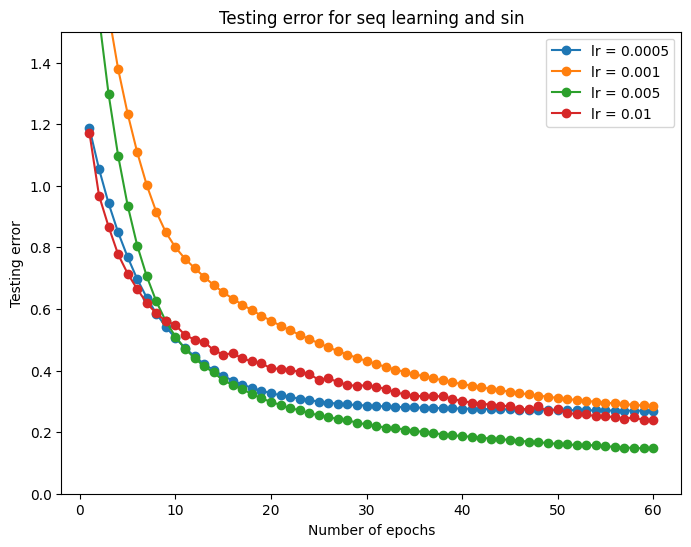

In [57]:
lr_list = [5*1e-4, 0.001, 0.005, 0.01]
nr_centers = 60
nr_epochs = 60
lses = np.zeros((len(lr_list), nr_epochs))
intervals = np.linspace(0, 2*np.pi, num=nr_centers + 1)
centers_noisy_sin_x = (intervals[:-1] + intervals[1:]) / 2
centers_noisy_sin = np.array([centers_noisy_sin_x, np.sin(2*centers_noisy_sin_x)]).T

for i in range(len(lr_list)):
  rbf = RBF(input_size=1, output_size=1, centers=centers_noisy_sin, width = 1)
  training_error_noisy_sin, _ = rbf._train_sequential(x_train, noisy_sin_train, x_test, sin_test, epochs = nr_epochs, lr = lr_list[i])
  lses[i,:] = training_error_noisy_sin



n = np.arange(1, nr_epochs+1, 1)
plt.figure(figsize=(8, 6))
plt.plot(n, lses[0,:], 'o-', label = 'lr = 0.0005')
plt.plot(n, lses[1,:], 'o-', label = 'lr = 0.001')
plt.plot(n, lses[2,:], 'o-', label = 'lr = 0.005')
plt.plot(n, lses[3,:], 'o-', label = 'lr = 0.01')
#plt.plot(n, lses[4,:], 'o-', label = 'lr = 0.05')
# plt.plot(n, lses[5,:], 'o-', label = 'lr = 0.01')
# plt.plot(n, lses[6,:], 'o-', label = 'lr = 0.5')
plt.ylim(0.0,1.5)
plt.xlabel('Number of epochs')
plt.ylabel('Testing error')
plt.legend()
plt.title('Testing error for seq learning and sin')
plt.show()

What are the main effects of changing the width of RBFs?
-> small width, localized function but may lead to overfitting
high width, smoother function but may underfit

How important is the positioning of the RBF nodes in the input space? What strategy did you choose? Is it better than random positioning of the RBF nodes?

Text(0.5, 1.0, 'Errors depending on placement of centers')

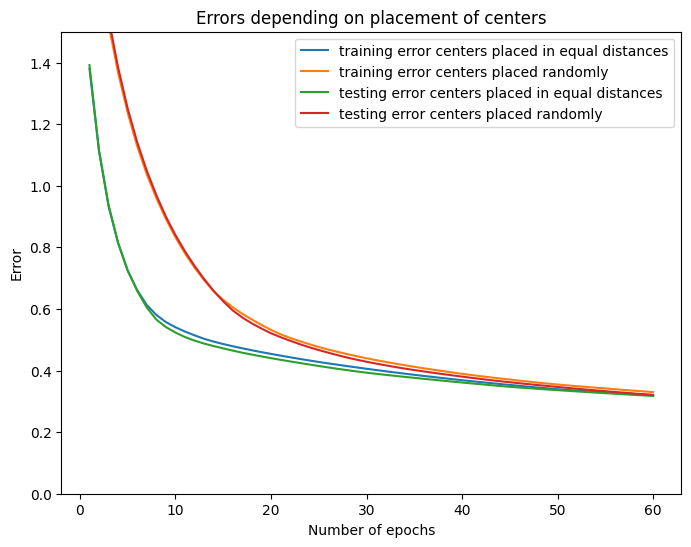

In [60]:
# previously placing them in equal distances
# now random:
nr_centers = 30
nr_epochs = 60
lr = 0.001
std = 1


intervals = np.linspace(0, 2*np.pi, num=nr_centers + 1)
centers_along_sin = ((intervals[:-1] + intervals[1:]) / 2).T

centers_random_sin = np.random.rand(nr_centers, 1)
centers_random_sin[:,0]  = centers_random_sin[:,0] * 2 * np.pi


rbf_along = RBF(input_size=1, output_size=1, centers=centers_along_sin, width = 1)
training_error_along, testing_error_along = rbf_along._train_sequential(x_train, noisy_sin_train, x_test, sin_test, epochs = nr_epochs, lr = lr)
rbf_random = RBF(input_size=1, output_size=1, centers=centers_random_sin, width = 1)
training_error_random, testing_error_random = rbf_random._train_sequential(x_train, noisy_sin_train, x_test, sin_test, epochs = nr_epochs, lr = lr)

n = np.arange(1, nr_epochs+1, 1)
plt.figure(figsize=(8, 6))
plt.plot(n, training_error_along, label = 'training error centers placed in equal distances')
plt.plot(n, training_error_random, label = 'training error centers placed randomly')
plt.plot(n, testing_error_along, label = 'testing error centers placed in equal distances')
plt.plot(n, testing_error_random, label = 'testing error centers placed randomly')
plt.ylim(0.0, 1.5)
plt.xlabel('Number of epochs')
plt.ylabel('Error')
plt.legend()
plt.title('Errors depending on placement of centers')



Please compare your optimal RBF network trained in batch mode with a
single-hidden-layer perceptron trained with backprop.

In [61]:
def test_backprop(patterns, targets, w, v):
  ndata = len(patterns)  # Number of data points (columns in patterns)

  hin = np.dot(w, np.vstack([patterns, np.ones((1, ndata))]))          # Adding bias to input patterns
  hout = np.vstack([2 / (1 + np.exp(-hin)) - 1, np.ones((1, ndata))])  # Hidden layer output with bias
  oin = np.dot(v, hout)
  out = 2 / (1 + np.exp(-oin)) - 1

  # calulate lse
  lse = np.mean(np.abs(out - targets))

  return lse

def backprop(input_neurons, hidden_neurons, output_neurons, pattern_train, target_train, pattern_val = None, target_val = None, lr=0.001, epochs=200, alpha=0.9):
    # Initialize w, v, dw, dv
    w = np.random.randn(hidden_neurons, input_neurons + 1)    # Weights for hidden layer (+1 for bias)
    v = np.random.randn(output_neurons, hidden_neurons + 1)   # Weights for output layer (+1 for bias)

    dw = np.zeros_like(w)  # Weight change matrix for hidden layer (matching w)
    dv = np.zeros_like(v)  # Weight change matrix for output layer (matching v)

    ndata = len(pattern_train)  # Number of data points (columns in patterns)

    # define learning curve metrics
    lses_train = []
    lses_val = []


    for epoch in range(epochs):
        # Forward pass
        hin = np.dot(w, np.vstack([pattern_train, np.ones((1, ndata))]))          # Adding bias to input patterns
        hout = np.vstack([2 / (1 + np.exp(-hin)) - 1, np.ones((1, ndata))])  # Hidden layer output with bias

        oin = np.dot(v, hout)
        out = 2 / (1 + np.exp(-oin)) - 1

        # Backward pass
        delta_o = (out - target_train) * ((1 + out) * (1 - out)) * 0.5         # Output layer delta
        delta_h = np.dot(v.T, delta_o) * ((1 + hout) * (1 - hout)) * 0.5  # Hidden layer delta
        delta_h = delta_h[:hidden_neurons, :]  # Exclude the bias row from delta_h

        # Weight updates
        dw = (dw * alpha) - np.dot(delta_h, np.vstack([pattern_train, np.ones((1, ndata))]).T) * (1 - alpha)
        dv = (dv * alpha) - np.dot(delta_o, hout.T) * (1 - alpha)

        # Update the weights using the learning rate
        w += dw * lr
        v += dv * lr

        # test
        lse_train = test_backprop(pattern_train, target_train, w, v)
        lses_train.append(lse_train)

        if pattern_val is not None and target_val is not None:
            lse_val = test_backprop(pattern_val, target_val, w, v)
            lses_val.append(lse_val)


    return w, v, lses_train, lses_val

In [63]:
# optimal sinus:

nr_centers = 60
std = 1

intervals = np.linspace(0, 2*np.pi, num=nr_centers + 1)
centers_optimal_sin = ((intervals[:-1] + intervals[1:]) / 2).T

rbf_opt_sin = RBF(input_size=1, output_size=1, centers=centers_optimal_sin, width = std)
_, testing_error_opt_sin = rbf_opt_sin._train_least_squares(x_train, noisy_sin_train, x_test, sin_test)

In [64]:
_, _ , _, testing_error_backprop = backprop(1, 60, 1, x_train, noisy_sin_train, x_test, sin_test)

final_testing_error_backprop = testing_error_backprop[-1]

print(testing_error_opt_sin)
print(final_testing_error_backprop)

0.03195800104688001
0.5543557185400209


In [65]:
# optimal square:

nr_centers = 60
std = 1

intervals = np.linspace(0, 2*np.pi, num=nr_centers + 1)
centers_optimal_squ = ((intervals[:-1] + intervals[1:]) / 2).T


rbf_opt_squ = RBF(input_size=1, output_size=1, centers=centers_optimal_squ, width = std)
_, testing_error_opt_squ = rbf_opt_squ._train_least_squares(x_train, noisy_squ_train, x_test, squ_test)

In [66]:
_, _ , _, testing_error_backprop = backprop(1, 60, 1, x_train, noisy_squ_train, x_test, squ_test)

final_testing_error_backprop = testing_error_backprop[-1]

print(testing_error_opt_squ)
print(final_testing_error_backprop)

0.23836004539553765
0.8017166342504669


Training RBF with least squares is faster as it solves one equation, whereas the NN updates the weights over several (in this case 200) epochs.
RBF learns more locally (whereever centers are placed) and NN more globally. Since the centers are in our case located in good positions (along the curve), the RBF outperforms the NN. In addition, the NN is prone to overfitting.
Generally, the LSEs are higher for the square function due to its discontinouties.

3.3 Competitive learning (CL) to initialise RBF units

Compare the CL-based approach with your earlier RBF network where you manually positioned RBF nodes in the input space for both noise-free and noisy approximation of sin(2x)

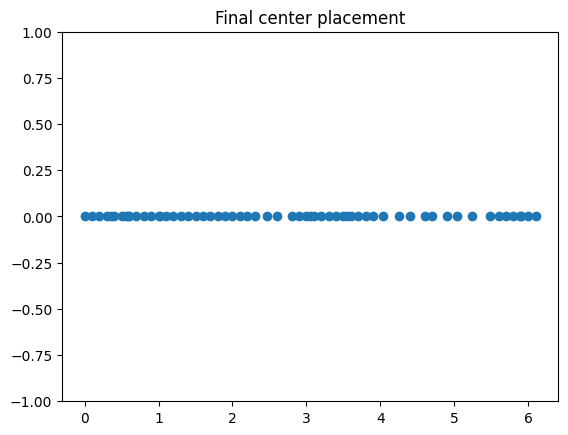

Text(0.5, 1.0, 'Errors depending on placement of centers - noise-free sinus')

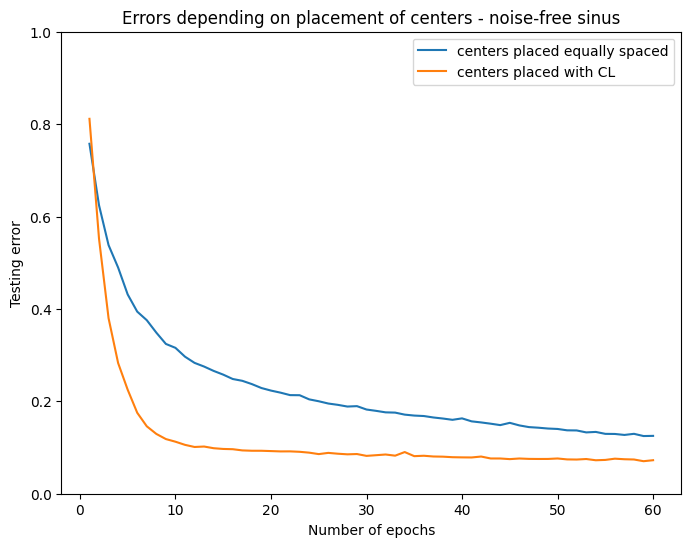

In [76]:
# noise-free sin

nr_epochs = 60
lr = 0.01
std = 1

rbf_CL = RBF(input_size=1, output_size=1, nr_centers = 60, range_x = [0, np.pi*2], width = 1)
rbf_CL._train_centers_CL_hard_competition(x_train, sin_train, epochs = 1000, lr = 0.5)
_, testing_error_CL = rbf_CL._train_sequential(x_train, sin_train, x_test, sin_test, epochs = nr_epochs, lr = lr)

rbf_along = RBF(input_size=1, output_size=1, centers=centers_optimal_sin, width = 1)
_, testing_error_along = rbf_along._train_sequential(x_train, sin_train, x_test, sin_test, epochs = nr_epochs, lr = lr)

n = np.arange(1, nr_epochs+1, 1)
plt.figure(figsize=(8, 6))
plt.plot(n, testing_error_along, label = 'centers placed equally spaced')
plt.plot(n, testing_error_CL, label = 'centers placed with CL')
plt.ylim(0, 1)
plt.xlabel('Number of epochs')
plt.ylabel('Testing error')
plt.legend()
plt.title('Errors depending on placement of centers - noise-free sinus')

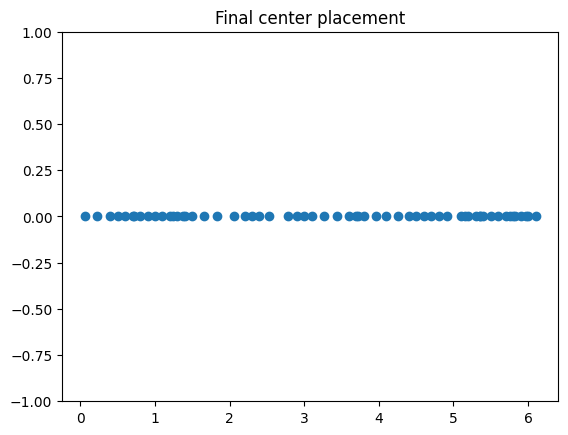

Text(0.5, 1.0, 'Errors depending on placement of centers - noisy sinus')

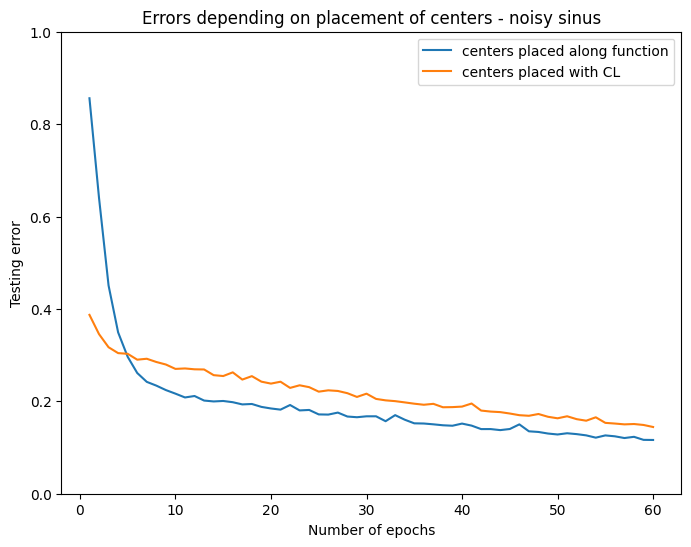

In [78]:
# noisy sin

rbf_CL = RBF(input_size=1, output_size=1, nr_centers = 60, range_x = [0, np.pi*2], width = 1)
rbf_CL._train_centers_CL_hard_competition(x_train, noisy_sin_train, epochs = 1000, lr = 0.5)
_, testing_error_CL = rbf_CL._train_sequential(x_train, noisy_sin_train, x_test, sin_test, epochs = nr_epochs, lr = lr)

rbf_along = RBF(input_size=1, output_size=1, centers=centers_optimal_sin, width = 1)
_, testing_error_along = rbf_along._train_sequential(x_train, noisy_sin_train, x_test, sin_test, epochs = nr_epochs, lr = lr)

n = np.arange(1, nr_epochs+1, 1)
plt.figure(figsize=(8, 6))
plt.plot(n, testing_error_along, label = 'centers placed along function')
plt.plot(n, testing_error_CL, label = 'centers placed with CL')
plt.ylim(0, 1)
plt.xlabel('Number of epochs')
plt.ylabel('Testing error')
plt.legend()
plt.title('Errors depending on placement of centers - noisy sinus')

Introduce a strategy to avoid dead units, e.g. by having more than a single
winner. Compare with the other version of our simple CL algorithm

In [ ]:
def train_centers_CL_hard_competition(X_train, centers, epochs = 200, lr = 0.01):

      hidden_size = centers.shape[0]
      # learning
      for _ in range(epochs*X_train.shape[0]):
        # randomly select one training vector
        shuffled_indices = np.random.permutation(X_train.shape[0])
        selected_X = X_train[shuffled_indices[0]]

        # find closesed unit with index n
        idx_min_distance = 0
        min_distance = 1000  # max distance is 6.59
        for n in range(hidden_size):
          distance = np.linalg.norm(selected_X - centers[n])
          if distance < min_distance:
            idx_min_distance = n
            min_distance = distance

        # update closesed unit closer to selected_vector
        centers[idx_min_distance] += lr*(selected_X-centers[idx_min_distance])


def train_centers_CL_soft_competition(X_train, centers, epochs = 200, lr = 0.01, leaky_lr = 0.001):

      hidden_size = centers.shape[0]
      # learning
      for i in range(epochs*X_train.shape[0]):
        # randomly select one training vector
        shuffled_indices = np.random.permutation(X_train.shape[0])
        selected_X = X_train[shuffled_indices[0]]

        # find closesed unit with index n
        idx_min_distance = 0
        min_distance = 1000
        for n in range(hidden_size):
          distance = np.linalg.norm(selected_X - centers[n])
          if distance < min_distance:
            idx_min_distance = n
            min_distance = distance

        # update closesed unit closer to selected_vector
        centers[idx_min_distance] += lr*(selected_X-centers[idx_min_distance])
        centers[~(np.arange(hidden_size) == idx_min_distance)] += leaky_lr*(selected_X - centers[~(np.arange(hidden_size) == idx_min_distance)])

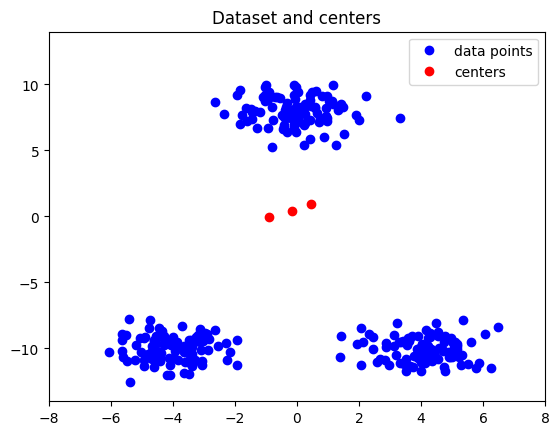

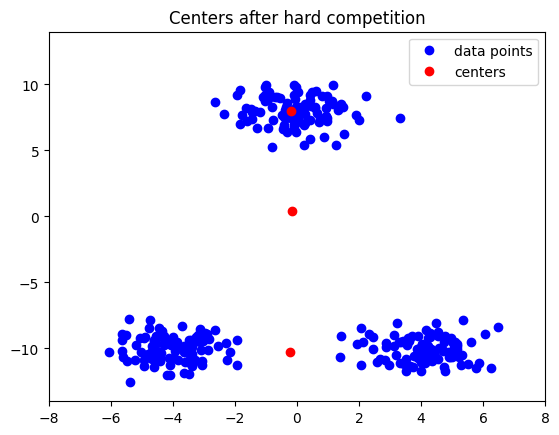

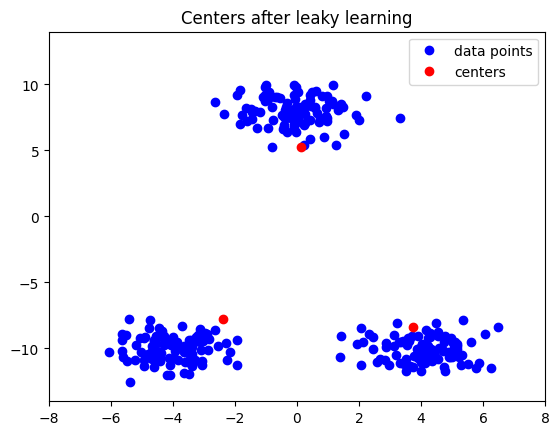

In [ ]:
mean1 = np.array([4,-10])
mean2 = np.array([-4, -10])
mean3 = np.array([0, 8])
cov = np.array([[1,0],[0,1]])
center_mean = np.array([0,0])

gaussian1 = np.random.multivariate_normal(mean1, cov, size=100)
gaussian2 = np.random.multivariate_normal(mean2, cov, size=100)
gaussian3 = np.random.multivariate_normal(mean3, cov, size=100)
gmm = np.concatenate((gaussian1, gaussian2,gaussian3))
centers = np.random.multivariate_normal(center_mean, cov, size=3)

lr = 0.1
leaky_lr = 0.01
n_iterations = 300

plt.plot(gmm[:,0], gmm[:,1], 'bo')
plt.plot(centers[:,0], centers[:,1], 'ro')
plt.xlim(-8, 8)
plt.ylim(-14, 14)
plt.title('Dataset and centers')
plt.legend(['data points','centers'])
plt.show()


train_centers_CL_hard_competition(gmm, centers, n_iterations, lr)
plt.plot(gmm[:,0], gmm[:,1], 'bo')
plt.plot(centers[:,0], centers[:,1], 'ro')
plt.xlim(-8, 8)
plt.ylim(-14, 14)
plt.title('Centers after hard competition')
plt.legend(['data points','centers'])
plt.show()

train_centers_CL_soft_competition(gmm, centers, n_iterations, lr, leaky_lr)
plt.plot(gmm[:,0], gmm[:,1], 'bo')
plt.plot(centers[:,0], centers[:,1], 'ro')
plt.xlim(-8, 8)
plt.ylim(-14, 14)
plt.title('Centers after leaky learning')
plt.legend(['data points','centers'])
plt.show()

ballist and balltest data

In [79]:
from google.colab import drive

drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/DD2437_Lab2_data/ballist.dat'
data_train = np.loadtxt(file_path)

# Split the data into input and output
input_data_train = data_train[:, :2]  # First two columns
output_data_train = data_train[:, 2:]  # Last two columns

file_path = '/content/drive/MyDrive/DD2437_Lab2_data/balltest.dat'
data_test = np.loadtxt(file_path)

# Split the data into input and output
input_data_test = data_test[:, :2]  # First two columns
output_data_test = data_test[:, 2:]  # Last two columns


# Check ranges
min_input = np.min(input_data_train)
max_input = np.max(input_data_train)

min_output = np.min(output_data_train)
max_output = np.max(output_data_train)

print(min_input)
print(max_input)

print(min_output)
print(max_output)

Mounted at /content/drive
0.001
0.999
0.0
0.816


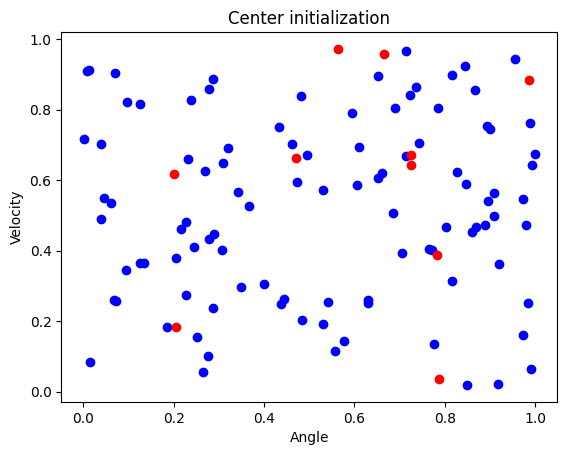

In [82]:
rbf_2D = RBF(input_size=2, output_size=2, nr_centers = 10, range_x = [0, 1], range_y = [0, 1])

plt.plot(input_data_train[:,0], input_data_train[:,1], 'bo')
plt.plot(rbf_2D.centers[:,0], rbf_2D.centers[:,1], 'ro')
plt.title('Center initialization')
plt.xlabel('Angle')
plt.ylabel('Velocity')
plt.show()


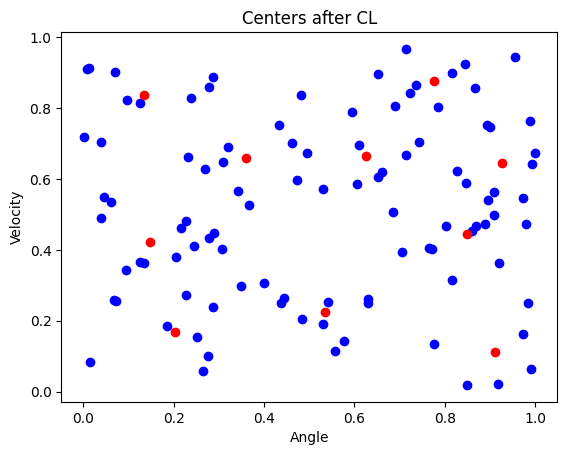

Text(0.5, 0.5, 'Velocity')

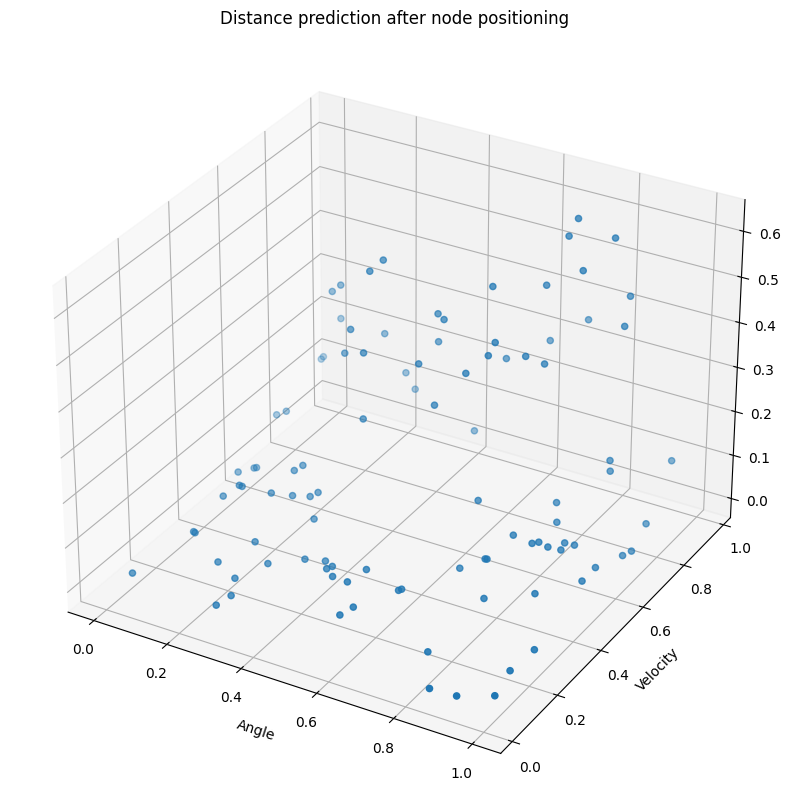

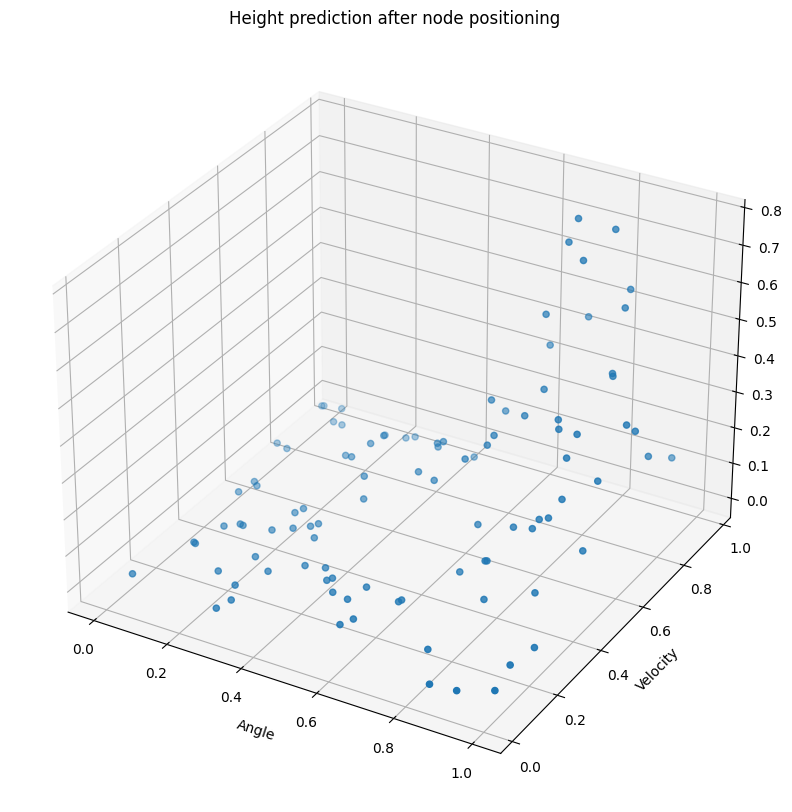

In [83]:
rbf_2D._train_centers_CL_hard_competition(X_train = input_data_train, y_train = output_data_train, epochs = 1000, lr = 0.1, plot = False)

plt.plot(input_data_train[:,0], input_data_train[:,1], 'bo')
plt.plot(rbf_2D.centers[:,0], rbf_2D.centers[:,1], 'ro')
plt.title('Centers after CL')
plt.xlabel('Angle')
plt.ylabel('Velocity')
plt.show()

training_error_2D, testing_error_2D = rbf_2D._train_least_squares(X_train = input_data_train, y_train = output_data_train, X_test = input_data_test, y_test = output_data_test)



plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
fg = ax.scatter3D(input_data_train[:,0],input_data_train[:,1], (rbf_2D._kernel_function(input_data_train)@rbf_2D.weights)[:,0])
plt.title('Distance prediction after node positioning')
plt.xlabel('Angle')
plt.ylabel('Velocity')

plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
fg = ax.scatter3D(input_data_train[:,0], input_data_train[:,1], (rbf_2D._kernel_function(input_data_train)@rbf_2D.weights)[:,1])
plt.title('Height prediction after node positioning')
plt.xlabel('Angle')
plt.ylabel('Velocity')




Text(0.5, 0.5, 'Velocity')

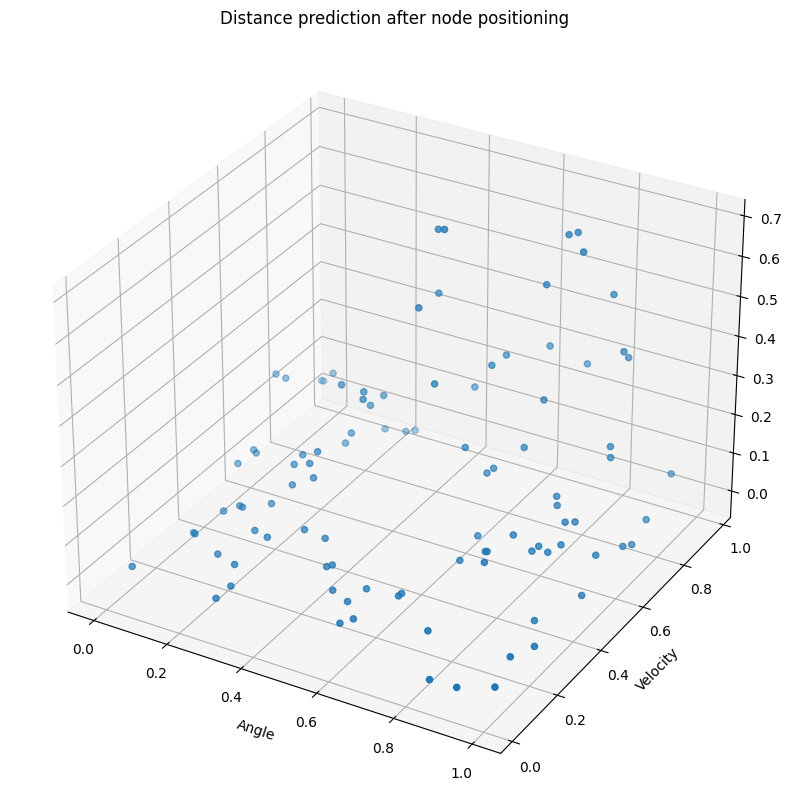

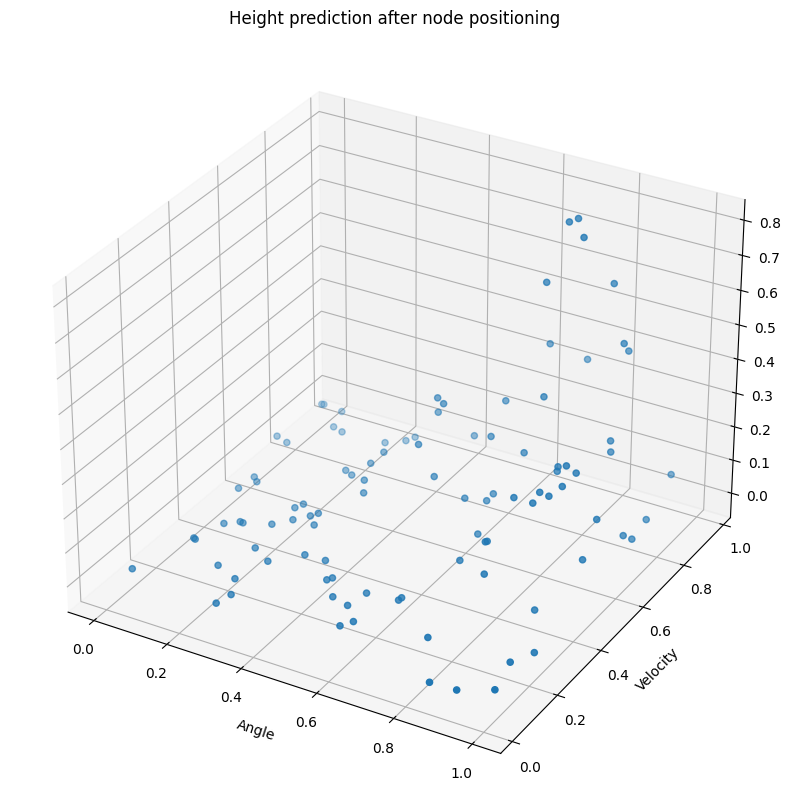